In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

In [10]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_095', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

def create_clusters(brain, n_clusters):
    t0 = time.time()
    clustering_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201110_analysis_superfly_supervoxels"
    super_to_cluster = brain.reshape(-1, 33840)
    connectivity = grid_to_graph(256,128)
    cluster_model = AgglomerativeClustering(n_clusters=n_clusters,
                                    memory=clustering_dir,
                                    linkage='ward',
                                    connectivity=connectivity)
    cluster_model.fit(super_to_cluster)
    return cluster_model

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    # def make_corr_map (self, n_clusters, cluster_model, behavior):
    #     corrs = []
    #     # remove zeros from correlation
    #     behavior_vector = flies[fly].fictrac.fictrac[behavior]
    #     non_zero_entries = np.where(behavior_vector != 0)[0]
    #     for i in range(n_clusters):
    #         cluster_indicies = np.where(cluster_model.labels_==i)[0]
    #         if len(cluster_indicies) > 2000:
    #             corrs.append(0)
    #         else:
    #             corrs.append(scipy.stats.pearsonr(behavior_vector[non_zero_entries],
    #                                               self.cluster_signals[i,non_zero_entries])[0])
    #     colored_by_betas = np.zeros(256*128)
    #     for cluster_num in range(n_clusters):
    #         cluster_indicies = np.where(cluster_model.labels_==cluster_num)[0]
    #         colored_by_betas[cluster_indicies] = corrs[cluster_num]
    #     colored_by_betas = colored_by_betas.reshape(256,128)
    #     self.maps[behavior] = colored_by_betas
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self, z):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Velocity ###
            low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
            self.fictrac[short] = low_res_behavior#/np.std(low_res_behavior)

            ### Clipped Velocities ###
            self.fictrac[short + '_pos'] = np.clip(self.fictrac[short], a_min=0, a_max=None)
            self.fictrac[short + '_neg'] = np.clip(self.fictrac[short], a_min=None, a_max=0)*-1

            ### Strongly Clipped Velocities ###
            # excludes points even close to 0
            #self.fictrac[short + '_pos_very'] = np.clip(self.fictrac[short], a_min=0.3, a_max=None)
            #self.fictrac[short + '_neg_very'] = np.clip(self.fictrac[short], a_min=None, a_max=-0.3)*-1

            ### Acceleration ###
            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short + 'h'] = high_res_behavior/np.std(high_res_behavior)

            accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
            accel = np.append(accel, 0)
            interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
            acl = interp_object(self.timestamps[:,z])
            acl[-1] = 0
            self.fictrac[short + 'a'] = acl#/np.std(acl)

            ### Clipped Acceleration ###
            self.fictrac[short + 'a' + '_pos'] = np.clip(self.fictrac[short + 'a'], a_min=0, a_max=None)
            self.fictrac[short + 'a' + '_neg'] = np.clip(self.fictrac[short + 'a'], a_min=None, a_max=0)*-1

        self.fictrac['YZ'] = np.sqrt(np.power(self.fictrac['Y'],2), np.power(self.fictrac['Z'],2))
        self.fictrac['YZh'] = np.sqrt(np.power(self.fictrac['Yh'],2), np.power(self.fictrac['Zh'],2))

In [3]:
z=20

In [29]:
#######################
### Load Superslice ###
#######################
brain_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/superslice_{}.nii".format(z) #<----------
brain = np.array(nib.load(brain_file).get_data(), copy=True)

In [30]:
cluster_model = create_clusters(brain, n_clusters)
#cluster_model_labels2 = cluster_model.labels_

In [32]:
cluster_model.labels_.shape

(32768,)

In [5]:
brain.shape

(256, 128, 3384, 10)

In [6]:
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)

In [34]:
cluster_model_labels[20,:].shape

(32768,)

In [12]:
fly_names = ['fly_087']

In [13]:
###################
### Build Flies ###
###################
flies = {}
for i, fly in enumerate(fly_names):
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac(z)
    flies[fly].load_brain_slice()
    flies[fly].get_cluster_averages(cluster_model_labels, n_clusters)


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 6.02 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.22 sec


In [17]:
cluster_model_labels

array([[1409, 1409, 1409, ..., 1384, 1400, 1400],
       [1979, 1979, 1979, ..., 1979, 1979, 1979],
       [1880, 1880, 1880, ..., 1880, 1880, 1880],
       ...,
       [1995, 1995, 1995, ..., 1995, 1995, 1995],
       [1790, 1790, 1790, ..., 1790, 1790, 1790],
       [1568, 1568, 1568, ..., 1568, 1568, 1568]])

In [22]:
flies['fly_087'].brain.shape

(256, 128, 3384)

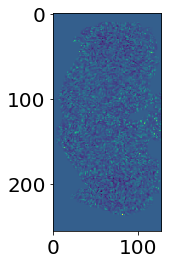

In [24]:
plt.imshow(flies['fly_087'].brain[:,:,0])

In [27]:
np.max(flies['fly_087'].brain)

15.788518905639648

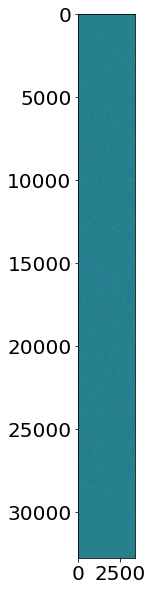

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(neural_data)

In [18]:
neural_data = flies['fly_087'].brain.reshape(-1, 3384)

In [28]:
np.where(cluster_model_labels==0)[0]

(array([ 0,  1,  2,  3,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  9,  9,  9,  9,
        10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14,
        14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18,
        18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22,
        22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26,
        27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31,
        31, 31, 31, 32, 32, 32, 32, 33, 33, 33, 33, 34, 34, 34, 34, 35, 35,
        35, 35, 36, 36, 36, 36, 37, 37, 37, 37, 38, 38, 38, 38, 39, 39, 39,
        39, 40, 40, 40, 40, 41, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43,
        44, 44, 45, 46, 47, 48]),
 array([ 3510,  3512,  3527, 10406, 17310, 27871, 2787

In [ ]:
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)

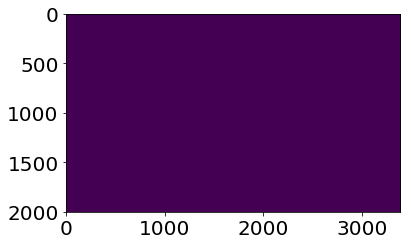

In [16]:
plt.imshow(flies['fly_087'].cluster_signals)

In [ ]:
#####################
### Pool behavior ###
#####################
not_clipped_behaviors = ['Y', 'Z', 'Ya', 'Za']
clipped_behaviors = ['Y_pos', 'Y_neg',
                     'Z_pos', 'Z_neg',
                     'Ya_pos', 'Ya_neg',
                     'Za_pos', 'Za_neg']
all_behaviors = not_clipped_behaviors + clipped_behaviors

pooled_behavior = {}
for j, behavior in enumerate(all_behaviors):
    pooled_behavior[behavior] = []
    for i,fly in enumerate(flies):
        pooled_behavior[behavior].append(flies[fly].fictrac.fictrac[behavior])
    pooled_behavior[behavior] = np.asarray(pooled_behavior[behavior]).flatten()

### Correct behavior stddev as a pooled group
stds = {}
for j, behavior in enumerate(not_clipped_behaviors):
    stds[behavior] = np.std(pooled_behavior[behavior])

for j, behavior in enumerate(all_behaviors):
    std_key = behavior.split('_')[0] # grab not split key
    for i,fly in enumerate(flies):
        flies[fly].fictrac.fictrac[behavior] = flies[fly].fictrac.fictrac[behavior]/stds[std_key]
    pooled_behavior[behavior] = pooled_behavior[behavior]/stds[std_key]